# Experimentación - DyGrEncoder



## 1. Obtención de datos



In [2]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import DyGrEncoderModel
from utils.trainer import  TrainerDryGrEncoder
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [3]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [4]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [68]:
def entrenar_y_evaluar_modelos_dygrencoder(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]


    for aggr, conv, lstm, out_lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"],  param_grid['out_lstm']))):
        
        print(f"Entrenando modelo con aggr={aggr}, conv={conv}, lstm={lstm},out_lstm={out_lstm}")

        model = DyGrEncoderModel(node_features=n_features, node_count=n_nodes,num_conv=conv, num_lstm=lstm, aggr=aggr,lstm_out =out_lstm, n_target=n_target, name="AGCRN", is_classification=True)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "LSTM_out": out_lstm,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'aggr': aggr, 'conv': conv, 'lstm': lstm, 'lstm_out': out_lstm}
            mejores_resultados = results_intermedio

        print("Parámetros: ", aggr, conv, lstm, out_lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [72]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import DyGrEncoderModel

In [73]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerDryGrEncoder

In [74]:

param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2],
    "out_lstm": [ 800,850, 900], #Number of input channels has to be smaller than number of output channels
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_dygrencoder(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "DyGrEncoder",target_names)

  0%|          | 0/24 [00:00<?, ?it/s]

Entrenando modelo con aggr=add, conv=1, lstm=1,out_lstm=800

==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5094 | Eval Loss: 1.3422 | Accuracy: 0.6133 | Precision: 0.4379 | Recall: 0.4731 | F1-Score: 0.4513 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.3520 | Eval Loss: 1.2909 | Accuracy: 0.6133 | Precision: 0.3408 | Recall: 0.4993 | F1-Score: 0.3994 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.3080 | Eval Loss: 1.2959 | Accuracy: 0.6133 | Precision: 0.4894 | Recall: 0.5198 | F1-Score: 0.4489 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.2761 | Eval Loss: 1.2997 | Accuracy: 0.6400 | Precision: 0.5623 | Recall: 0.5484 | F1-Score: 0.4821 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.2699 | Eval Loss: 1.2944 | Accuracy: 0.5867 | Precision: 0.4264 | Recall: 0.4855 | F1-Score: 0.4485 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 1.2565 | Eval Loss: 1.289

  4%|▍         | 1/24 [05:27<2:05:28, 327.34s/it]

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.40      0.67      0.50        15
           2       0.27      0.33      0.30         9
           3       0.25      0.05      0.09        19
           4       0.76      0.90      0.83        29

    accuracy                           0.55        84
   macro avg       0.46      0.49      0.45        84
weighted avg       0.51      0.55      0.50        84

preds:  torch.Size([])
test loss: 1.329544, test accuracy: 0.5476, test precision: 0.4575, test recall: 0.4898, test F1-score: 0.4516
Parámetros:  add 1 1 800
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 800, 'Loss_final': 1.0163146257400513, 'Accuracy_eval': 0.6266666666666667, 'Precision_eval': 0.5081028438121338, 'Recall_eval': 0.523841890867753, 'F1_eval': 0.4983369168066949, 'Loss_eval': 1.2552554607391357, 'Loss_tst': 1.3295443058013916, 'Accuracy_tst': 0.5476190476190477, 'Precisio

  8%|▊         | 2/24 [11:26<2:06:50, 345.94s/it]

              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.36      0.53      0.43        15
           2       0.30      0.33      0.32         9
           3       0.36      0.21      0.27        19
           4       0.72      0.79      0.75        29

    accuracy                           0.51        84
   macro avg       0.46      0.46      0.45        84
weighted avg       0.51      0.51      0.50        84

preds:  torch.Size([])
test loss: 1.350512, test accuracy: 0.5119, test precision: 0.4603, test recall: 0.4574, test F1-score: 0.4490
Parámetros:  add 1 1 850
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 850, 'Loss_final': 1.069093942642212, 'Accuracy_eval': 0.6210256410256411, 'Precision_eval': 0.5239558000714588, 'Recall_eval': 0.5215574081091323, 'F1_eval': 0.49673172663043325, 'Loss_eval': 1.255673885345459, 'Loss_tst': 1.350512146949768, 'Accuracy_tst': 0.5119047619047619, 'Precision

 12%|█▎        | 3/24 [17:28<2:03:39, 353.31s/it]

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.35      0.73      0.48        15
           2       0.33      0.33      0.33         9
           3       0.00      0.00      0.00        19
           4       0.77      0.83      0.80        29

    accuracy                           0.54        84
   macro avg       0.42      0.50      0.44        84
weighted avg       0.46      0.54      0.48        84

preds:  torch.Size([])
test loss: 1.352798, test accuracy: 0.5357, test precision: 0.4197, test recall: 0.4955, test F1-score: 0.4441
Parámetros:  add 1 1 900
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'LSTM_out': 900, 'Loss_final': 1.0325795412063599, 'Accuracy_eval': 0.6197435897435898, 'Precision_eval': 0.48979388786268446, 'Recall_eval': 0.5170353353543008, 'F1_eval': 0.48477818747057355, 'Loss_eval': 1.2601970434188843, 'Loss_tst': 1.3527977466583252, 'Accuracy_tst': 0.5357142857142857, 'Preci

 17%|█▋        | 4/24 [26:09<2:19:49, 419.47s/it]

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.32      0.73      0.45        15
           2       0.40      0.22      0.29         9
           3       0.29      0.11      0.15        19
           4       0.79      0.66      0.72        29

    accuracy                           0.52        84
   macro avg       0.50      0.51      0.47        84
weighted avg       0.54      0.52      0.50        84

preds:  torch.Size([])
test loss: 1.367285, test accuracy: 0.5238, test precision: 0.5030, test recall: 0.5099, test F1-score: 0.4750
Parámetros:  add 1 2 800
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 800, 'Loss_final': 1.1342536211013794, 'Accuracy_eval': 0.5979487179487178, 'Precision_eval': 0.47940821883233536, 'Recall_eval': 0.4996452254641909, 'F1_eval': 0.46843373909701636, 'Loss_eval': 1.2954282760620117, 'Loss_tst': 1.3672845363616943, 'Accuracy_tst': 0.5238095238095238, 'Preci

 21%|██        | 5/24 [36:04<2:32:50, 482.68s/it]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.31      0.53      0.39        15
           2       0.29      0.44      0.35         9
           3       0.25      0.05      0.09        19
           4       0.79      0.76      0.77        29

    accuracy                           0.51        84
   macro avg       0.46      0.49      0.45        84
weighted avg       0.51      0.51      0.49        84

preds:  torch.Size([])
test loss: 1.345876, test accuracy: 0.5119, test precision: 0.4592, test recall: 0.4911, test F1-score: 0.4527
Parámetros:  add 1 2 850
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 850, 'Loss_final': 1.0784937143325806, 'Accuracy_eval': 0.6023076923076923, 'Precision_eval': 0.521821913908979, 'Recall_eval': 0.5060193255020842, 'F1_eval': 0.4811950387360564, 'Loss_eval': 1.291514277458191, 'Loss_tst': 1.3458757400512695, 'Accuracy_tst': 0.5119047619047619, 'Precision

 25%|██▌       | 6/24 [46:29<2:39:19, 531.08s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.37      0.73      0.49        15
           2       0.25      0.11      0.15         9
           3       0.50      0.16      0.24        19
           4       0.80      0.83      0.81        29

    accuracy                           0.57        84
   macro avg       0.51      0.52      0.48        84
weighted avg       0.57      0.57      0.54        84

preds:  torch.Size([])
test loss: 1.330824, test accuracy: 0.5714, test precision: 0.5119, test recall: 0.5160, test F1-score: 0.4777
Parámetros:  add 1 2 900
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'LSTM_out': 900, 'Loss_final': 1.0833632946014404, 'Accuracy_eval': 0.5946153846153847, 'Precision_eval': 0.47544278241286736, 'Recall_eval': 0.49653135657446, 'F1_eval': 0.46178665237627603, 'Loss_eval': 1.2650500535964966, 'Loss_tst': 1.3308241367340088, 'Accuracy_tst': 0.5714285714285714, 'Precisi


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.344170, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899


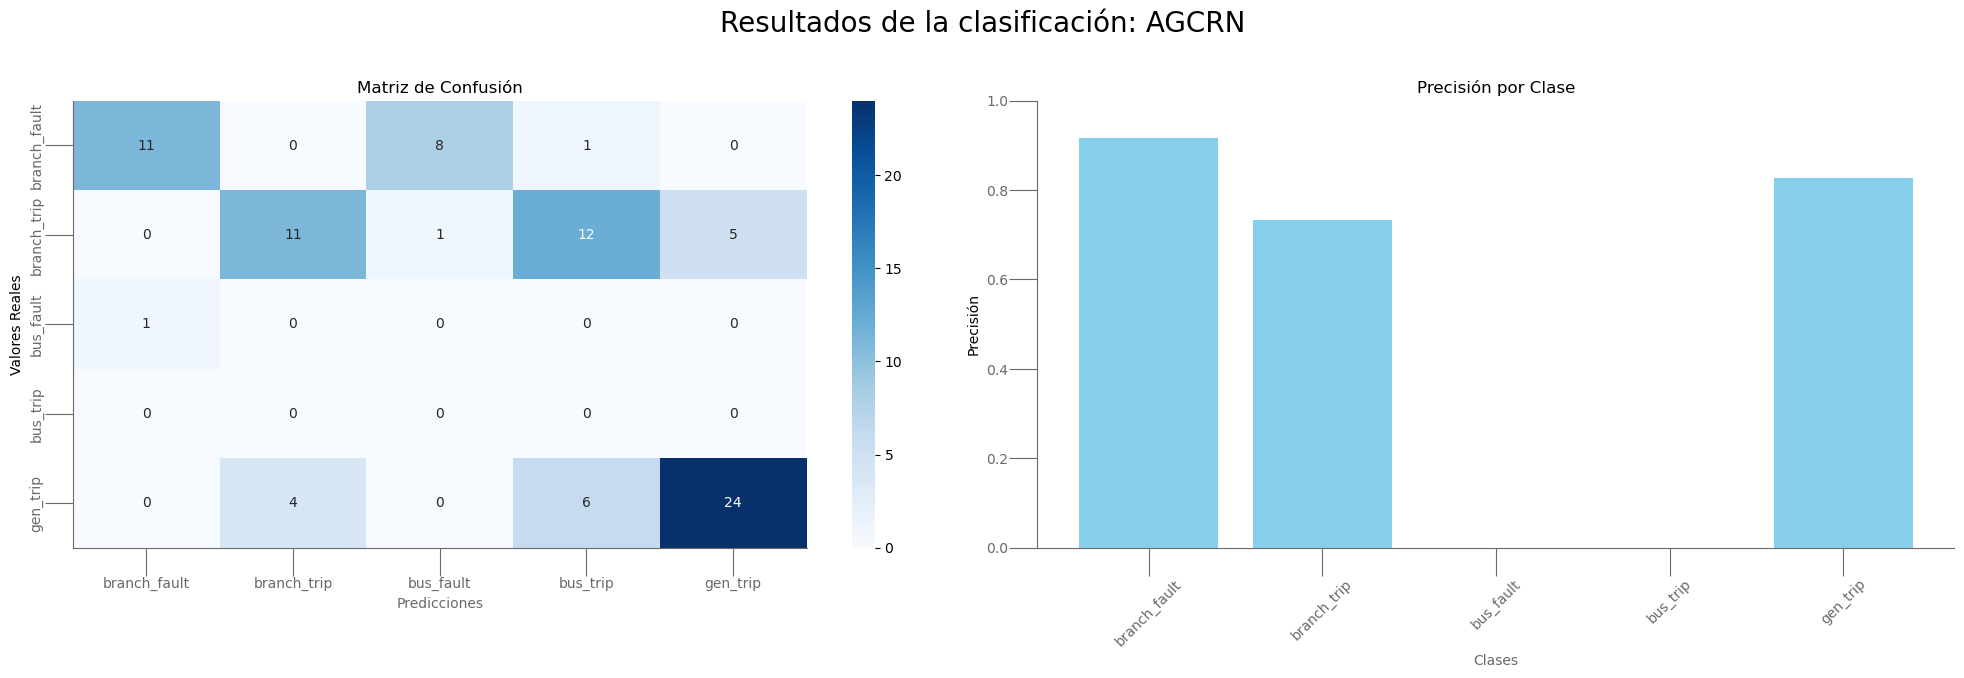

In [ ]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "DyGrEncoder")

In [52]:
name_model ="DyGrEncoder"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0     MPNN_LSTM     {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH       {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH       {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN  {'hidden': 50, 'Embedding': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841   
3  ../experimentos_split/results/clasificacion/aj...  1.344170   1.293829   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.270143       0.600000        0.438630     0.498128  0.435153   
1    1.075731       0.671875        0.630667     0.671140  0.635028   
2    1.076455       0.706667        0.666